# Pretty Example
Make a pretty example case and a movie for the group website.

In [1]:
#import matplotlib
#matplotlib.use('Qt5Agg')

import subprocess
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.sun import constants
from sunpy.net import Fido,attrs
from sunpy.time import TimeRange
import yt

import synthesizAR
import synthesizAR.extrapolate
from synthesizAR.interfaces import EbtelInterface
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

## Magnetogram and 3D Field
First grab a recent magnetogram with FIDO. Specifically, we're looking for AR 12699.

In [ ]:
result_hmi = Fido.search(
    attrs.Time(TimeRange('2017/12/25 22:57:00',1*u.min)),
    attrs.Instrument('HMI') & attrs.vso.Physobs('LOS_magnetic_field'),)

In [3]:
#hmi_files = Fido.fetch(result_hmi)
hmi_files = '/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2017_12_25_22_58_30_tai_magnetogram.fits'

In [4]:
hmi = sunpy.map.Map(hmi_files).rotate()

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [5]:
cx,cy = 340*u.arcsec,340*u.arcsec
wx,wy = 250*u.arcsec,250*u.arcsec
lc = SkyCoord(cx - wx/2,cy - wy/2,frame=hmi.coordinate_frame)
rc = SkyCoord(cx + wx/2,cy + wy/2,frame=hmi.coordinate_frame)
hmi_zoom = hmi.submap(lc,rc).resample([100, 100]*u.pixel)

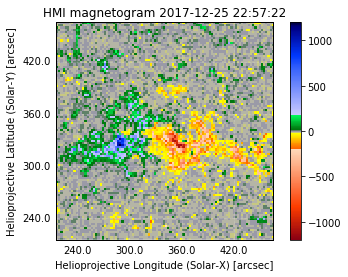

In [8]:
fig = plt.figure()
ax = fig.gca(projection=hmi_zoom)
hmi_zoom.plot(cmap='hmimag',vmin=-1.2e3,vmax=1.2e3,axes=ax)
plt.colorbar()

Now, extrapolate a 3D vector magnetic field from the lower boundary.

In [9]:
extrapolator = synthesizAR.extrapolate.ObliqueSchmidt(hmi_zoom, 0.25*constants.radius, 100*u.pixel)

In [10]:
B_field = extrapolator.extrapolate()

In [ ]:
ds = extrapolator.as_yt(B_field)

Plot unweighted projections with YT

In [ ]:
ds.domain_width.value[0]

In [ ]:
fig = plt.figure()
fig.set_figwidth(20)
# See http://matplotlib.org/mpl_toolkits/axes_grid/api/axes_grid_api.html
# These choices of keyword arguments produce two colorbars, both drawn on the
# right hand side.  This means there are only two colorbar axes, one for Density
# and another for temperature.  In addition, axes labels will be drawn for all
# plots.
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (3, 3),
                axes_pad = 1.0,
                label_mode = "all",
                share_all=False,
                cbar_location="right",
                cbar_mode="edge",
                cbar_size="5%",
                cbar_pad="0%")

cuts = ['x', 'y', 'z']
fields = ['Bx','By','Bz']
wi = [(1,2),(2,0),(0,1)]

for i, field in enumerate(fields):
    for j, direction in enumerate(cuts):
        # Load the data and create a single plot
        p = yt.ProjectionPlot(ds, direction, field, 
                              #origin='lower-right-domain',
                              #axes_unit='cm',
                              center=ds.domain_center,
                              width=((ds.domain_width.value[wi[j][0]],'cm'),
                                     (ds.domain_width.value[wi[j][1]],'cm')))

        # This forces the ProjectionPlot to redraw itself on the AxesGrid axes.
        plot = p.plots[field]
        plot.figure = fig
        plot.axes = grid[3*i + j].axes
        plot.cax = grid.cbar_axes[0]

        # Finally, redraw the plot.
        p._setup_plots()
        
        p.figure_size = 30

Plot unweighted projections with matplotlib

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/numpy/ma/core.py:6592: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


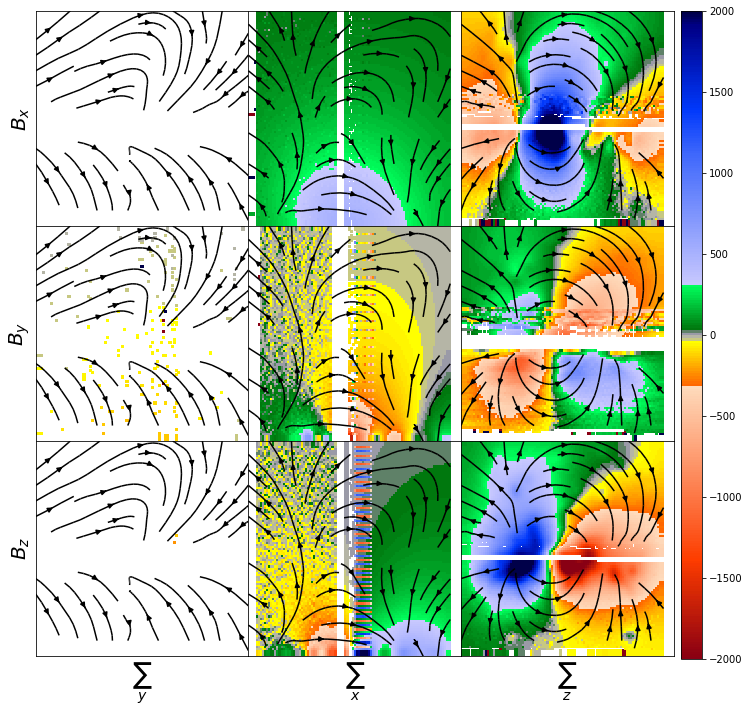

In [11]:
#x,y = np.linspace(-1,1,100),np.linspace(-1,1,100)
#y_grid,x_grid = np.meshgrid(x,y)
#plt.pcolormesh(y_grid,x_grid,B_field.z.sum(axis=2).value,cmap='hmimag',vmin=-1.5e3,vmax=1.5e3)
#plt.streamplot(x,y,B_field.x.sum(axis=2).value,
#               B_field.y.sum(axis=2).value,color='k',density=0.5)

fields = ((0,(2,1),'x'), (1,(0,2),'y'), (2,(0,1),'z'))
labs_ax = ('y', 'x', 'z')
fig,axes = plt.subplots(3,3,figsize=(9.75,10))
ax1_grid,ax2_grid = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
for i in range(3):
    for j in range(3):
        if j == 2:
            b_sum = B_field[fields[i][0]].value.sum(axis=j)
        else:
            b_sum = B_field[fields[i][0]].value.sum(axis=j).T
        im = axes[i,j].pcolormesh(ax1_grid,ax2_grid,b_sum,vmin=-2e3,vmax=2e3,cmap='hmimag')
        axes[i,j].streamplot(ax1_grid[0,:],ax2_grid[:,0],
                             B_field[fields[j][1][0]].sum(axis=2).value,
                             B_field[fields[j][1][1]].sum(axis=2).value,color='k',density=0.5)
        axes[i,j].get_xaxis().set_ticks([])
        axes[i,j].get_yaxis().set_ticks([])
        if j == 0:
            axes[i,j].set_ylabel(r'$B_{}$'.format(fields[i][2]),fontsize=20)
        if i == 2:
            axes[i,j].set_xlabel(r'$\sum_{}$'.format(labs_ax[j]),fontsize=20)

fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0,right=0.965)
cax = fig.add_axes([0.975,0.08,0.03,0.9])
fig.colorbar(im,cax=cax)

In [ ]:
fieldlines = extrapolator.trace_fieldlines(B_field,1000,loop_length_range=[2e9,1e11]*u.cm,mask_threshold=0.05)

## Field and Loops

In [ ]:
active_region = synthesizAR.Field(hmi_zoom, fieldlines=fieldlines)

In [ ]:
active_region.peek(line_frequency=2,alpha=0.3)

## Loop Hydrodynamics
Next, we'll run an EBTEL simulation for each of our traced fieldlines. 

In [ ]:
class RandomNanoflares(object):
    def __init__(self,heating_options):
        self.heating_options = heating_options
        
    def calculate_event_properties(self,loop):
        self.number_events = 1
        start_time = np.random.uniform(low=0,high=self.base_config['total_time'])
        max_energy = (self.heating_options['stress_level']*loop.field_strength.mean().value)**2/(8.*np.pi)
        return {'magnitude':[max_energy/(self.heating_options['duration']/2.)],
                'rise_start':[start_time],
                'rise_end':[start_time+self.heating_options['duration']/2],
                'decay_start':[start_time+self.heating_options['duration']/2],
                'decay_end':[start_time+self.heating_options['duration']]}

In [ ]:
heating_options = {
    'duration':200.0,
    'stress_level':0.3,
}
heating_model = RandomNanoflares(heating_options)

In [ ]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 1e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 100.0

In [ ]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/pretty_example/hydro_config/',
                                 '/storage-home/w/wtb2/data/pretty_example/hydro_results/')

In [ ]:
active_region.configure_loop_simulations(ebtel_interface)

In [ ]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [ ]:
for loop in active_region.loops:
    ebtel_runner(loop)

In [ ]:
active_region.load_loop_simulations(ebtel_interface,
                                    savefile='/storage-home/w/wtb2/data/pretty_example/loop_parameters.h5')

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(8,5),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in active_region.loops[::]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.1,lw=1)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C1',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1,lw=1)
    
axes[0].set_xlim([0,10000])
axes[0].set_ylim([0,20])
axes[1].set_ylim([0,40])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

Save the active region 

In [ ]:
active_region.save(savedir='/storage-home/w/wtb2/data/pretty_example/field_checkpoint')

Reload it as needed

## Computing Emission
This part is a bit more tricky. We need to construct a new instrument and observer for each timestep and adjust the observing coordinate as some function of time. It will be easiest to keep latitude as a constant and adjust longitude as a function of time, from $\Phi_a$ to $\Phi_b$.

It is also best to choose an interval near the middle of our simulation interval so that we capture as many filled loops as possible.

## Visualization